# Balanced allocations

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import psutil
import concurrent.futures
import matplotlib.pyplot as plt
from typing import Callable, Dict, List, Tuple
from strategies import one_choice, two_choice, beta_choice, partial_information

NUM_CORES = psutil.cpu_count(logical=False)


def run_experiment(
    strategies: Dict[str, Callable], 
    batch_size: int, 
    m: int, 
    T: int, 
    save_plot: bool, 
    plot_name: str
) -> None:    
    """
    Runs an experiment to simulate multiple ball-into-bin strategies, measuring the average gap in bin load distribution over multiple trials.

    Args:
        strategies (dict): A dictionary of strategies to simulate. Keys are strategy names, values are strategy functions.
        batch_size (int): The number of balls placed in each iteration of the simulation.
        m (int): The number of bins used in the simulation.
        T (int): The number of trials to average for each value of n (number of balls).
        save_plot (bool): If True, saves the plot of the results as a PDF.
        plot_name (str): The filename to save the plot as if save_plot is True.

    Returns:
        None. Displays or saves a plot showing the average gap as a function of the number of balls for each strategy.
    """
    n_values = range(batch_size, m**2 + batch_size, batch_size)
    gaps = np.zeros((len(strategies), len(n_values)))
    stddevs = np.zeros_like(gaps)
    
    # Run in parallel
    with concurrent.futures.ProcessPoolExecutor(max_workers=NUM_CORES) as executor:
        results = executor.map(compute_gaps, n_values,
                               [batch_size] * len(n_values),
                               [m] * len(n_values),
                               [T] * len(n_values),
                               [list(strategies.values())] * len(n_values)
                              )
        
        # Extract results and populate gaps and stddevs
        for idx, (mean_gaps, std_gaps) in enumerate(results):
            gaps[:, idx] = mean_gaps
            stddevs[:, idx] = std_gaps

    # Plotting
    labels = strategies.keys()
    plt.figure(figsize=(10, 6))
    for i, label in enumerate(labels):
        plt.plot(n_values, gaps[i, :], marker='.', label=label)
        plt.fill_between(n_values, gaps[i, :] - stddevs[i, :], gaps[i, :] + stddevs[i, :], alpha=0.2)
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(0, m**2 + 1000, 1000), rotation=45)
    plt.xlabel("Number of Balls (n)")
    plt.ylabel(f"Average of Gap (G_n) for {T} trials")
    
    plt.legend()
    if save_plot:
        plt.savefig(f"{plot_name}.pdf")
    plt.show()

def compute_gaps(
    n: int, 
    batch_size: int, 
    m: int, 
    T: int, 
    strategies: List[Callable]
) -> Tuple[np.ndarray, np.ndarray]:    
    """
    Computes the average gap and standard deviation in bin loads for a given number of balls across multiple trials for various strategies.

    Args:
        n (int): Total number of balls distributed across bins in each trial.
        batch_size (int): Number of balls placed in each iteration of the simulation.
        m (int): The number of bins in the simulation.
        T (int): The number of trials to perform for each strategy.
        strategies (list): List of strategy functions (or function tuples) to evaluate.

    Returns:
        tuple: A tuple containing:
            - mean_gaps (numpy.ndarray): The mean gap across bins for each strategy.
            - stddev_gaps (numpy.ndarray): The standard deviation of the gap for each strategy.
    """
    gaps = np.zeros((len(strategies), T))
    for trial in range(T):
        bins = np.zeros((len(strategies), m))
        
        for _ in range(n // batch_size):
            for i, func in enumerate(strategies):
                if isinstance(func, tuple):
                    func[0](bins[i], batch_size, m, func[1])
                else:
                    func(bins[i], batch_size, m)
        for i in range(len(strategies)):
            gaps[i, trial] = compute_gap(bins[i], n, m)
    return np.mean(gaps, axis=1), np.std(gaps, axis=1)

def compute_gap(    
    bins: np.ndarray, 
    n: int, 
    m: int
) -> float:
    """
    Computes the gap, defined as the difference between the maximum bin load and the average load across all bins.

    Args:
        bins (numpy.ndarray): Array representing the current load of each bin.
        n (int): Total number of balls distributed across bins.
        m (int): Number of bins.

    Returns:
        float: The gap between the maximum load and the average load.
    """
    return np.max(bins) - n / m


## Experiment parameters

In [2]:
# Generate the plots as PDF
SAVE_FIGS=False

# Number of bins
m = 100
# Different d values for batch size
d_batches = np.arange(m, 21 * m, m)
#np.append(d_batches, 1)

# Number of trials for averaging
T = 10 
# Different beta values for (1 + beta)-choice
beta_values = [0.25, 0.5, 0.75] 

## Gap for different strategies considering $d$-batch

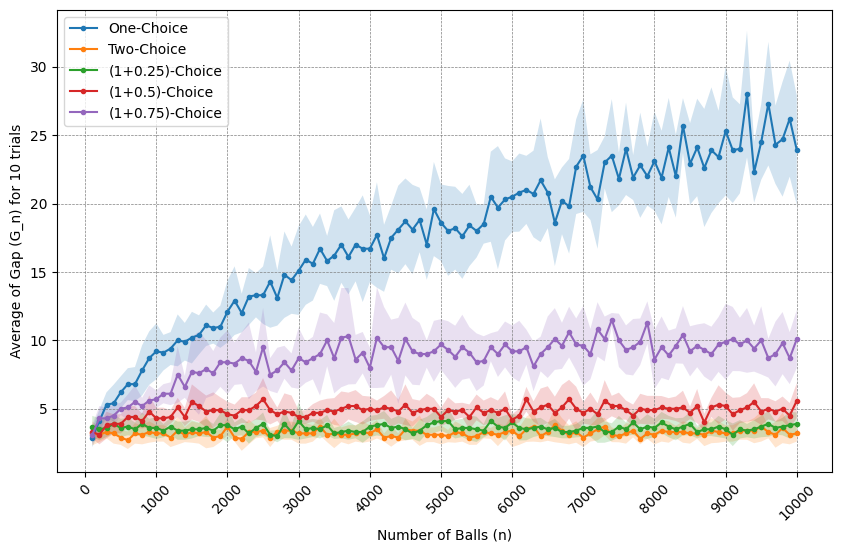

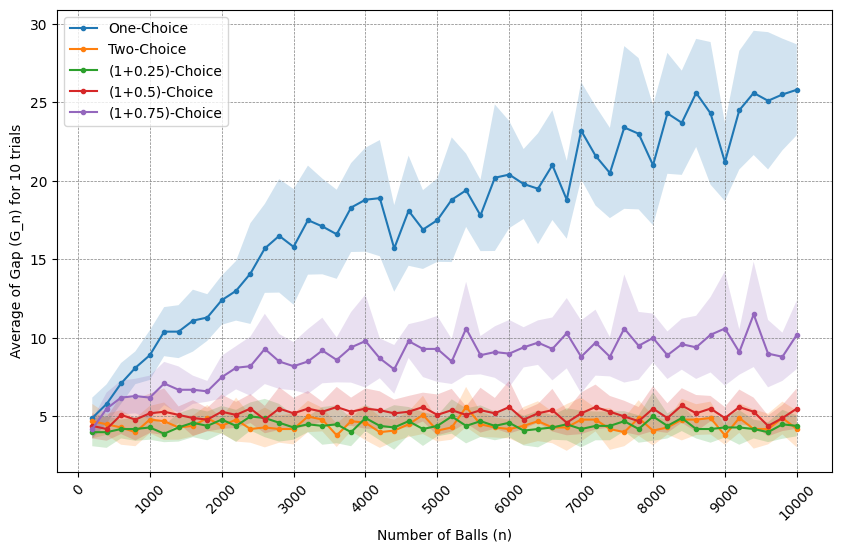

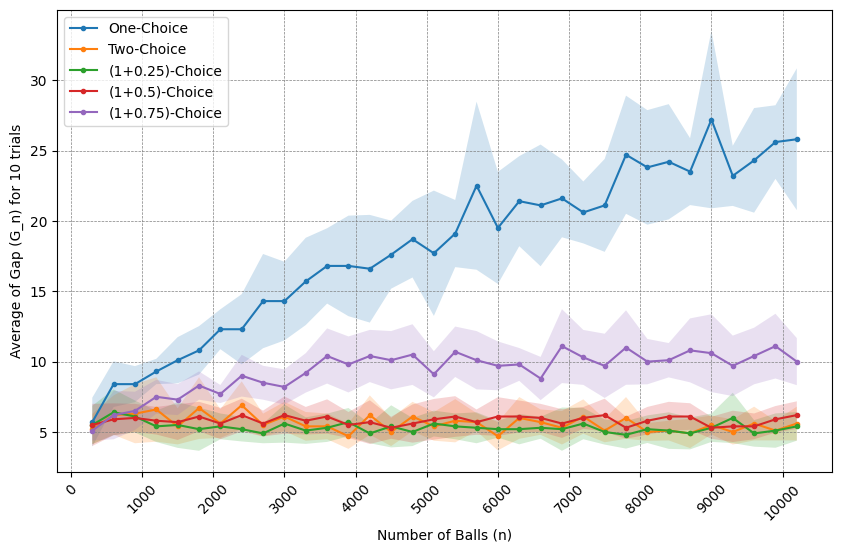

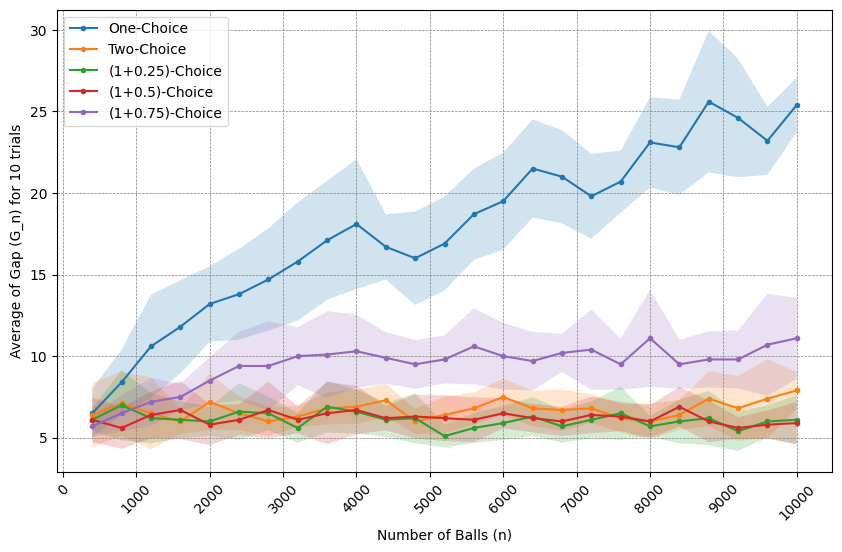

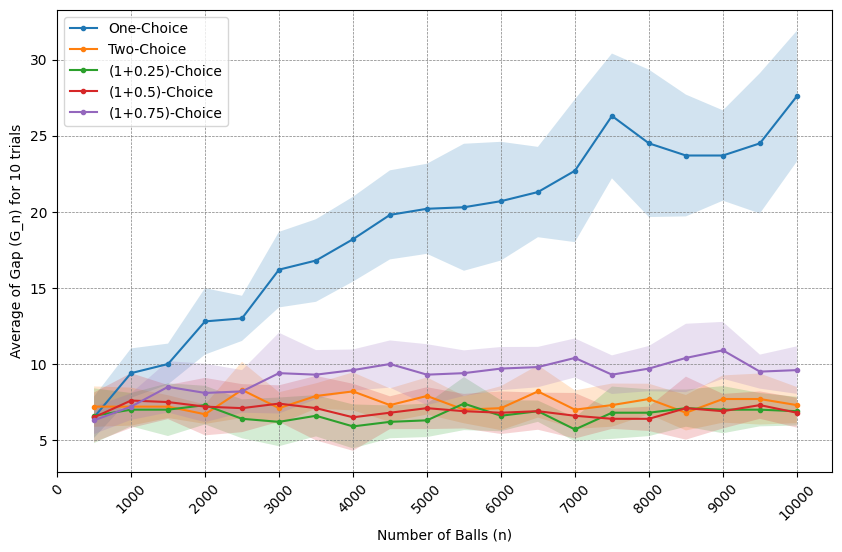

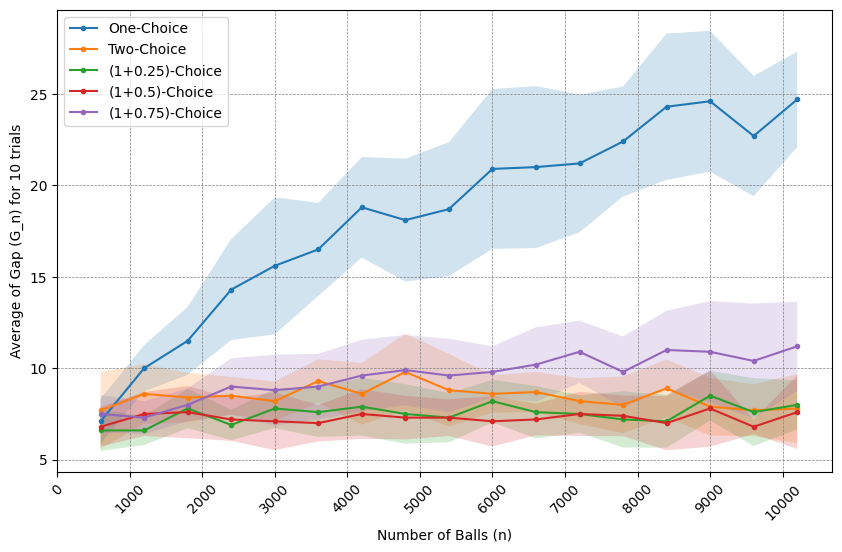

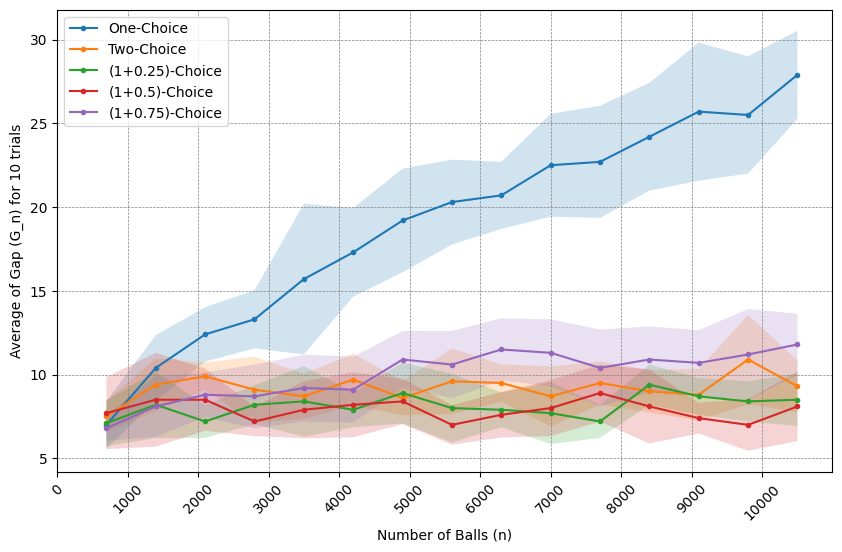

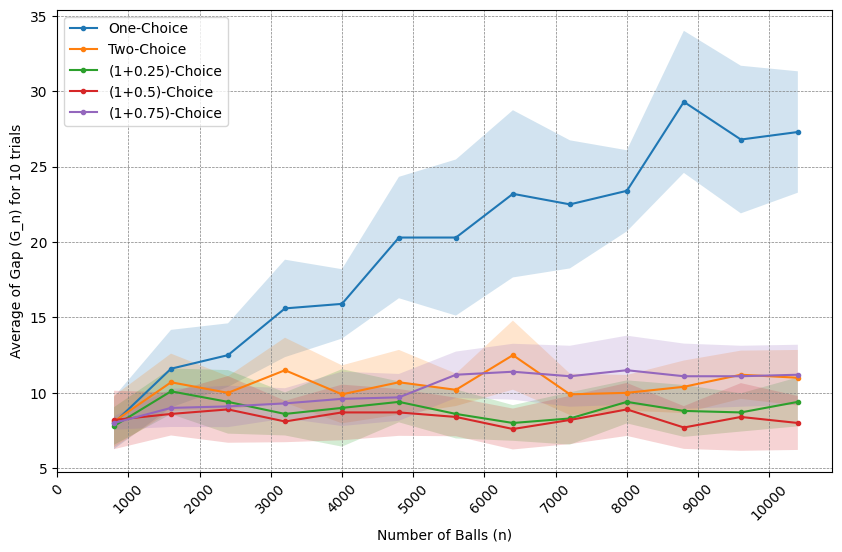

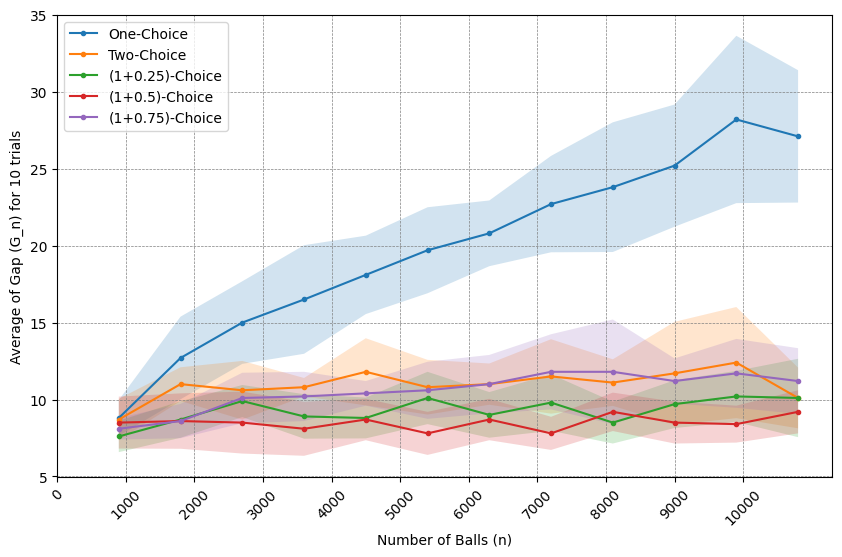

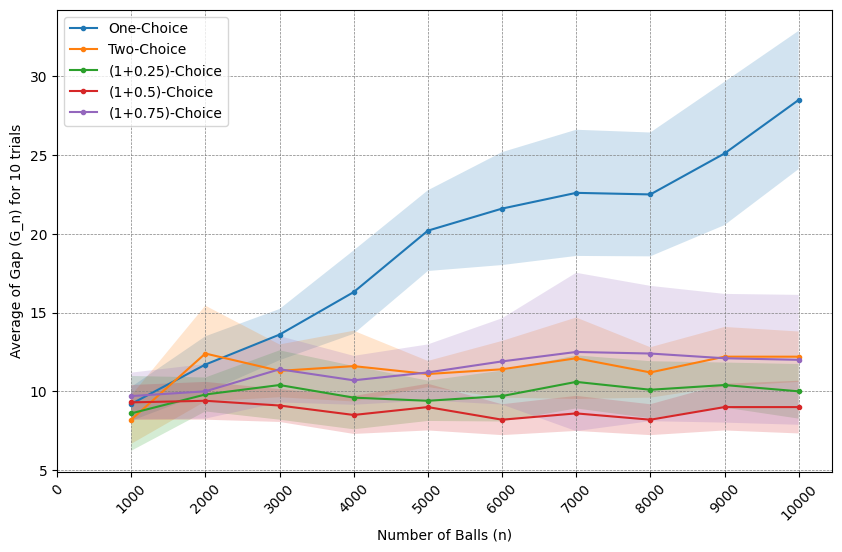

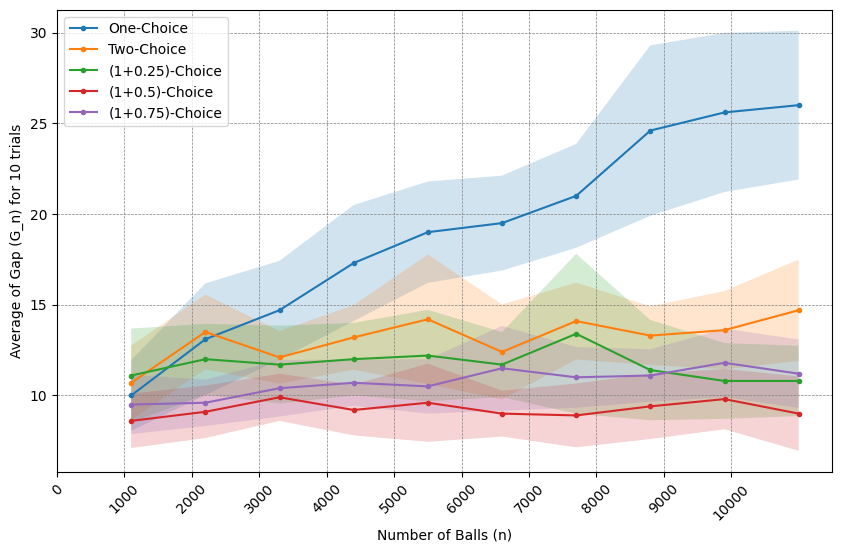

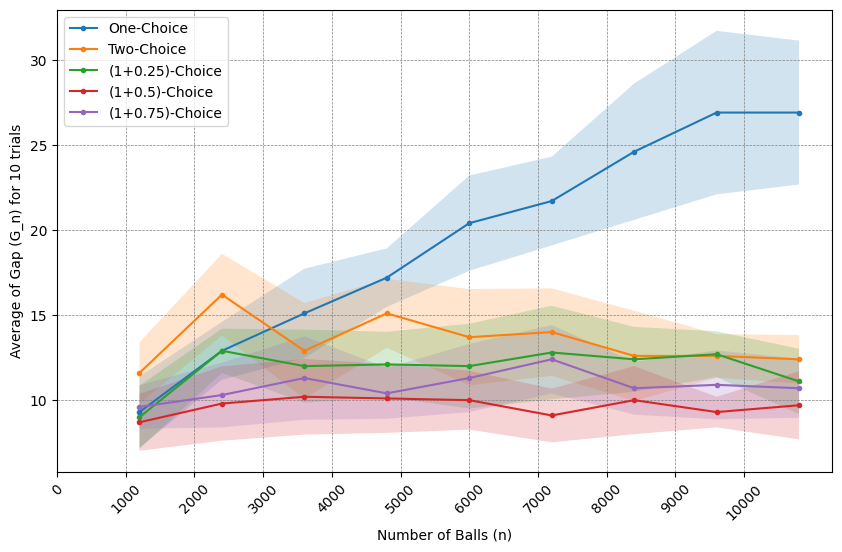

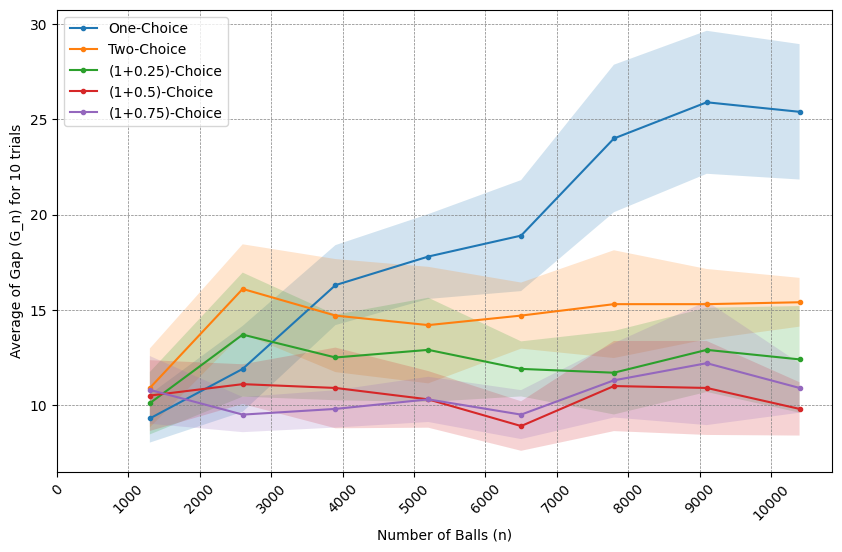

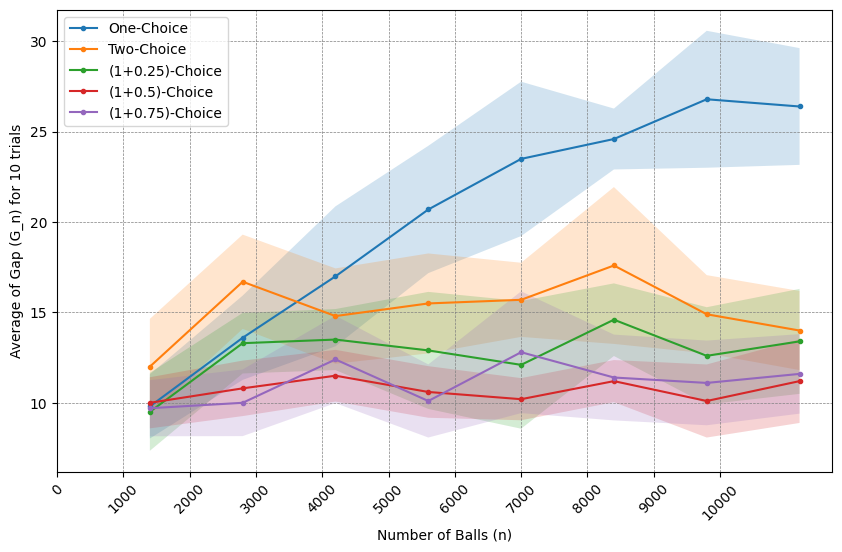

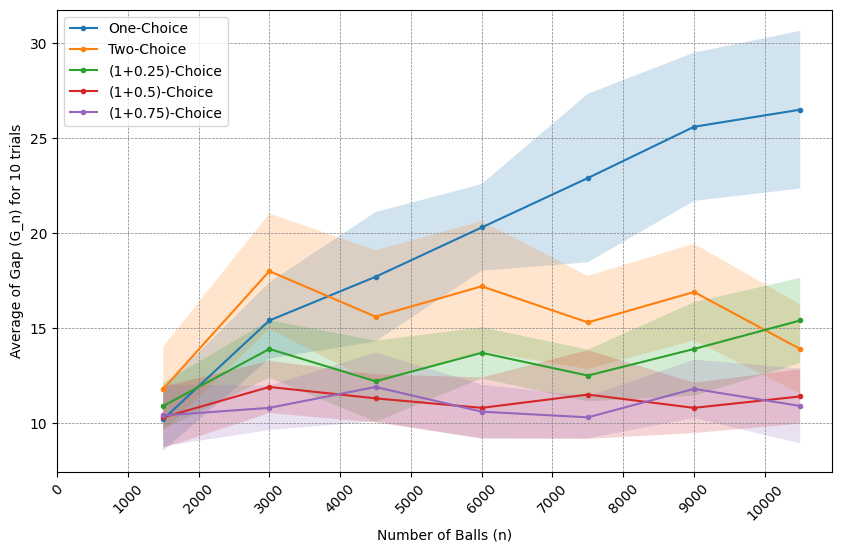

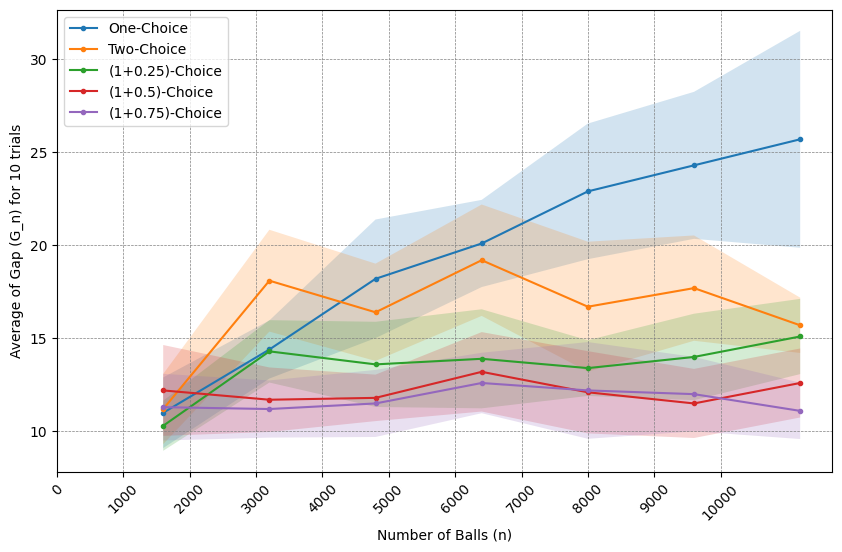

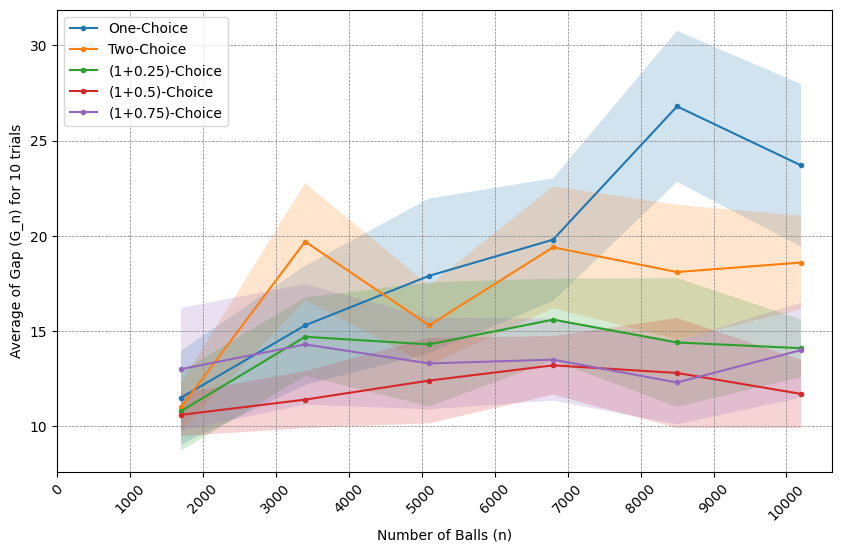

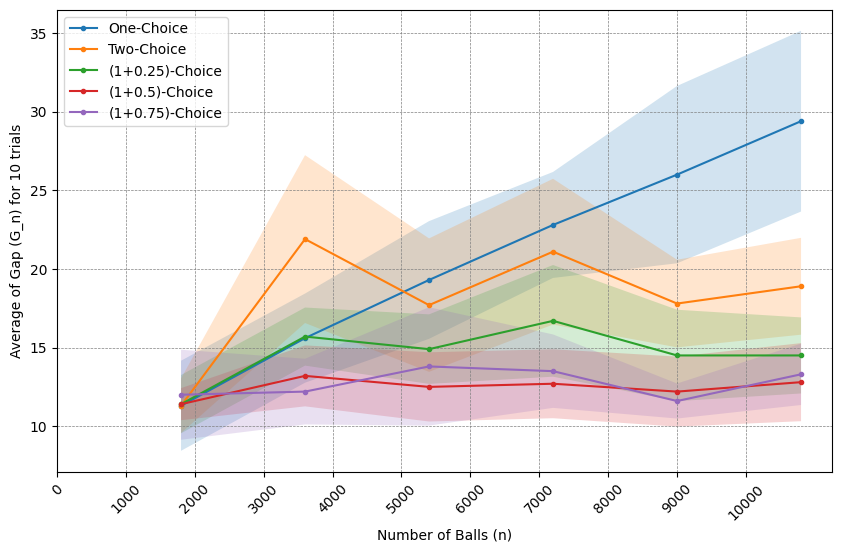

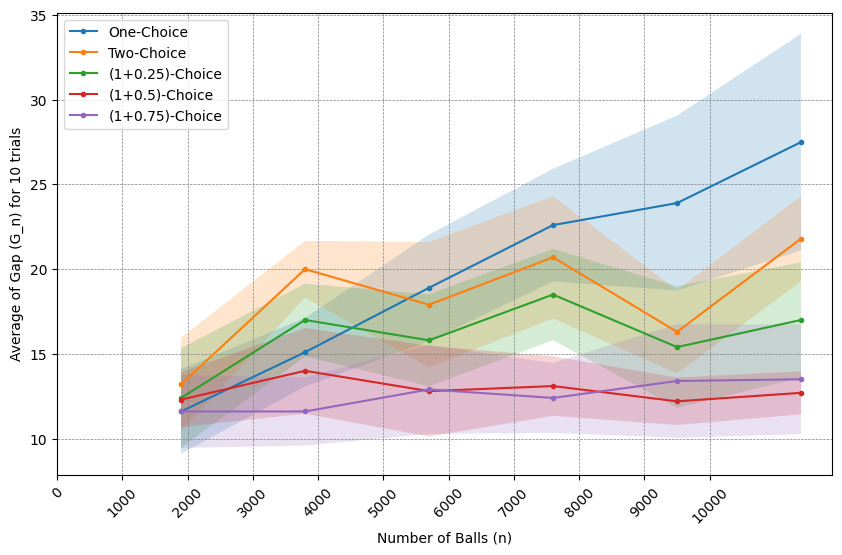

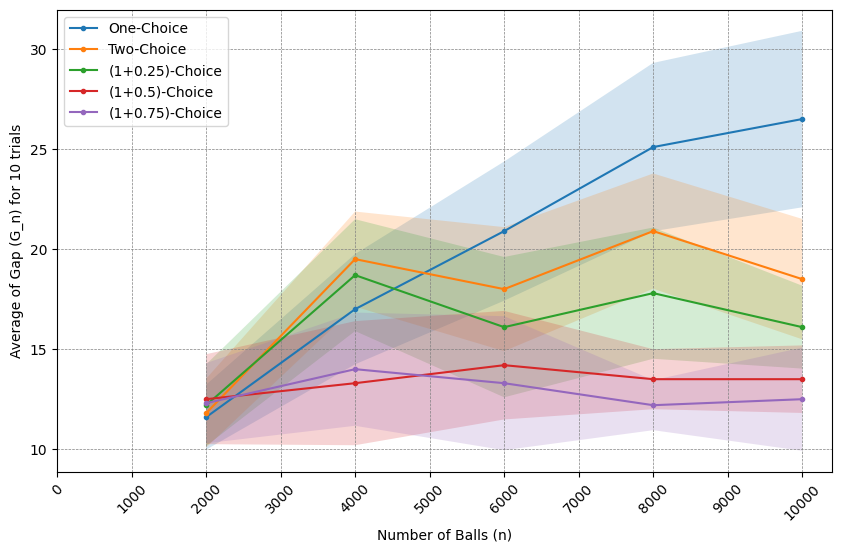

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

strategies = { 
               "One-Choice":  one_choice,
               "Two-Choice" : two_choice 
             }
beta_strategies = {f"(1+{beta})-Choice": (beta_choice, beta) for beta in beta_values}
strategies.update(beta_strategies)

for batch_size in d_batches:
    run_experiment(strategies, 
                    batch_size,
                    m,
                    T,
                    SAVE_FIGS, 
                    f"different_allocation-{m}_m-{batch_size}_batch")
    

## Gap for partial information strategies considering $d$-batch

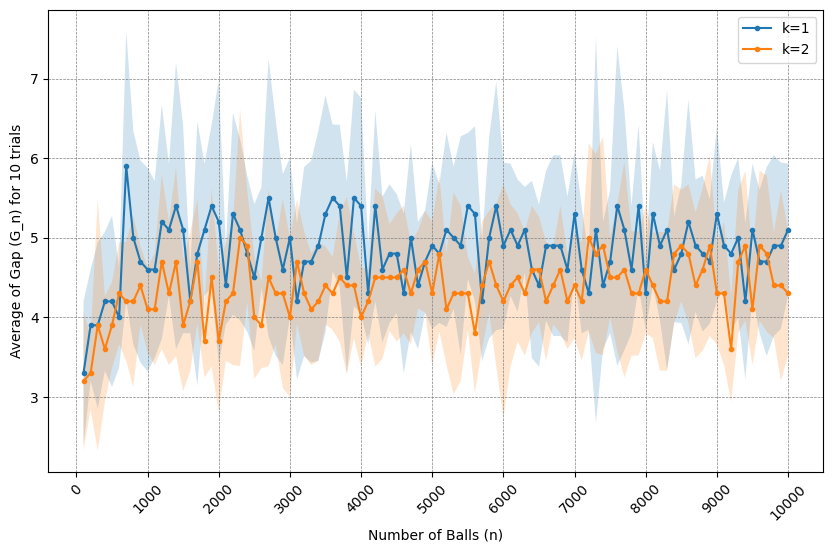

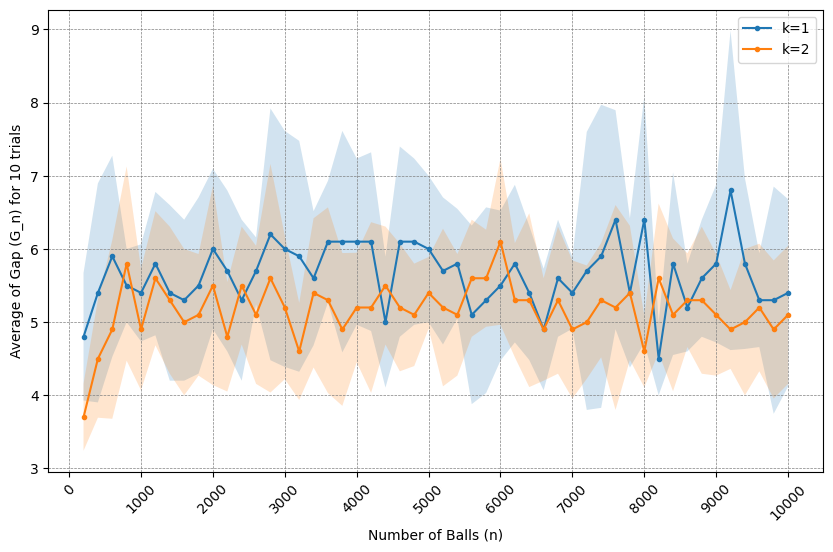

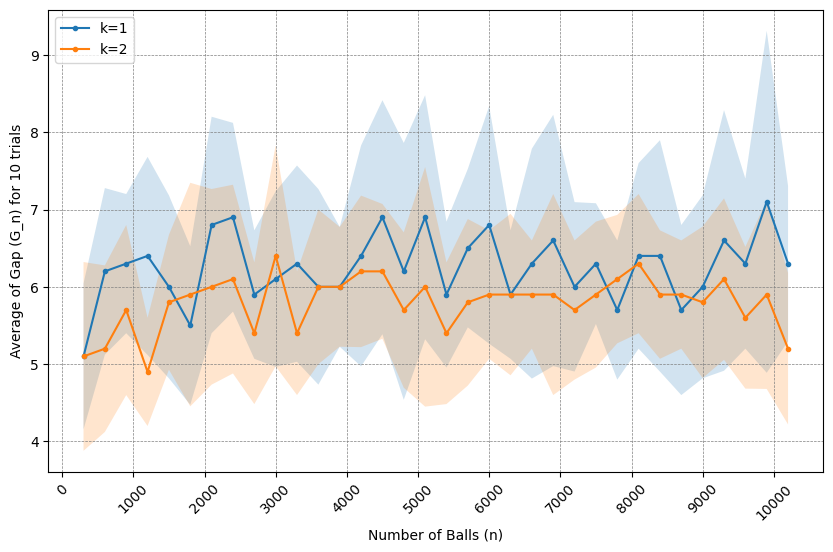

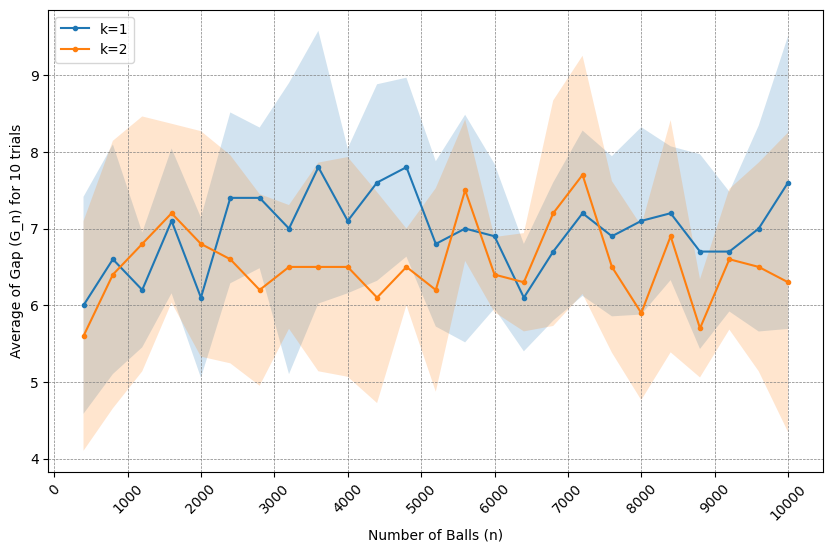

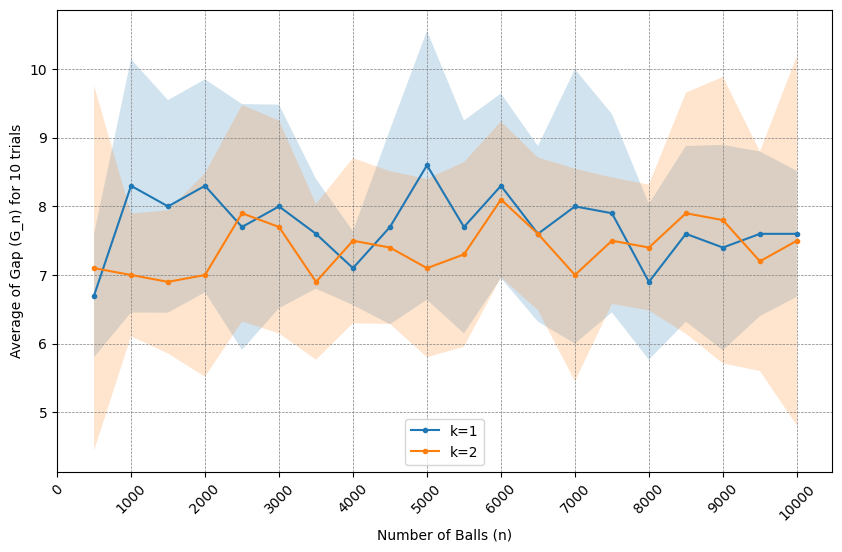

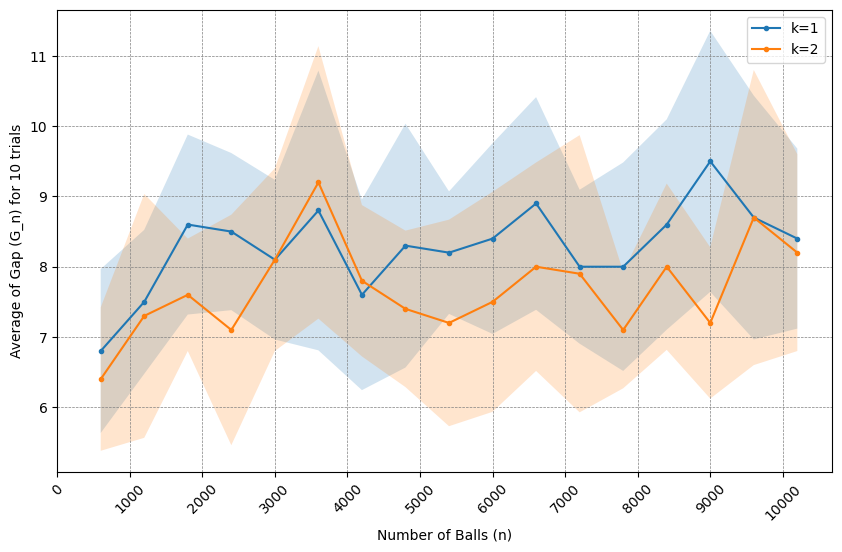

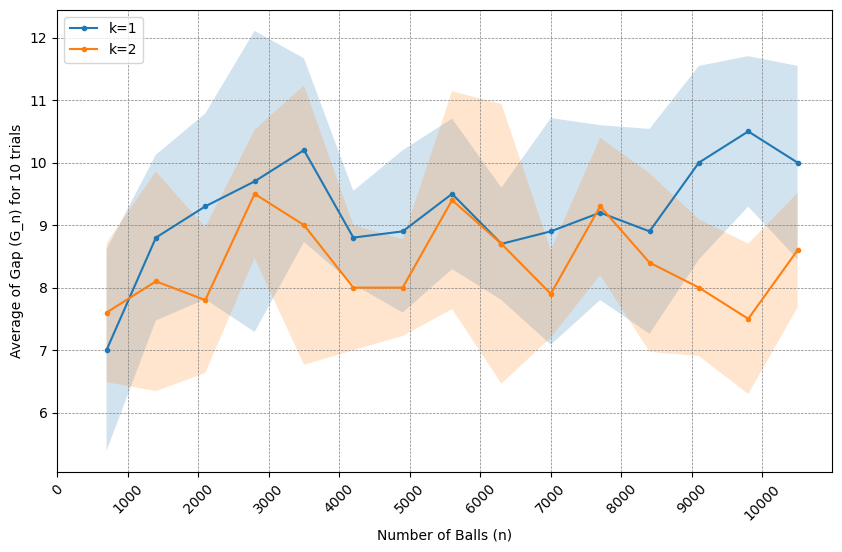

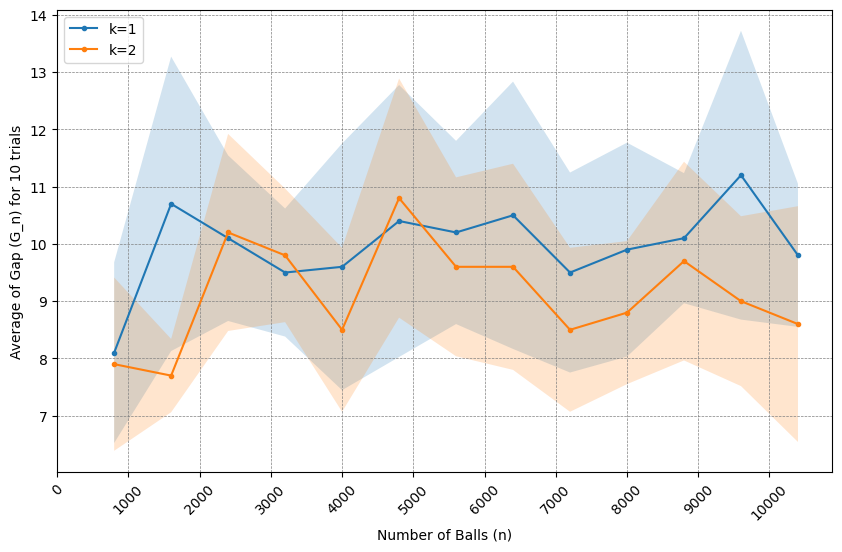

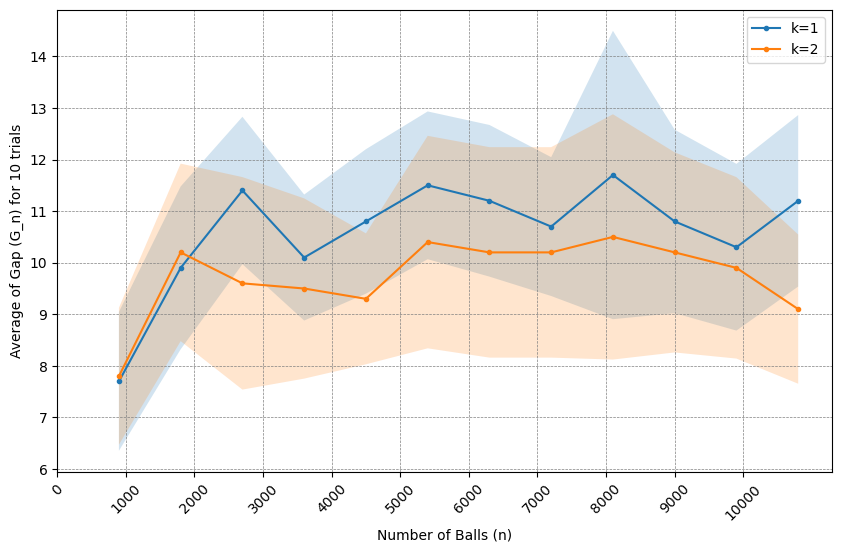

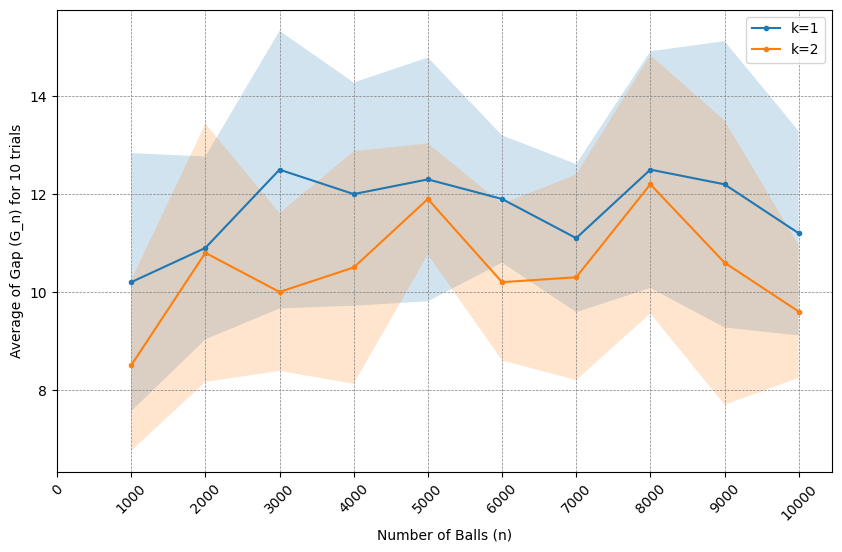

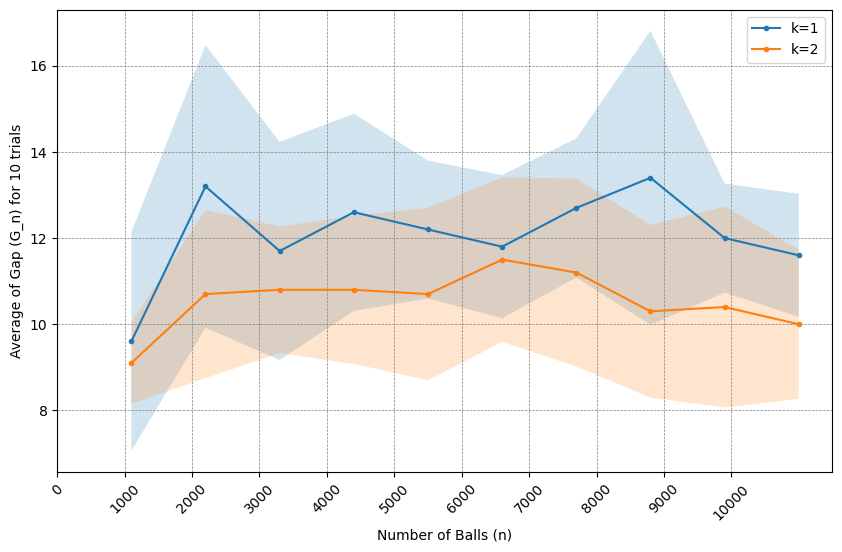

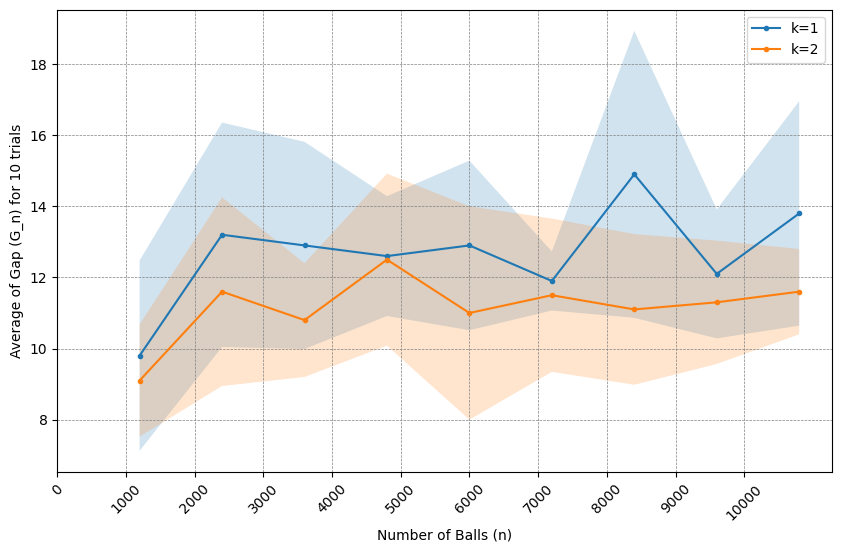

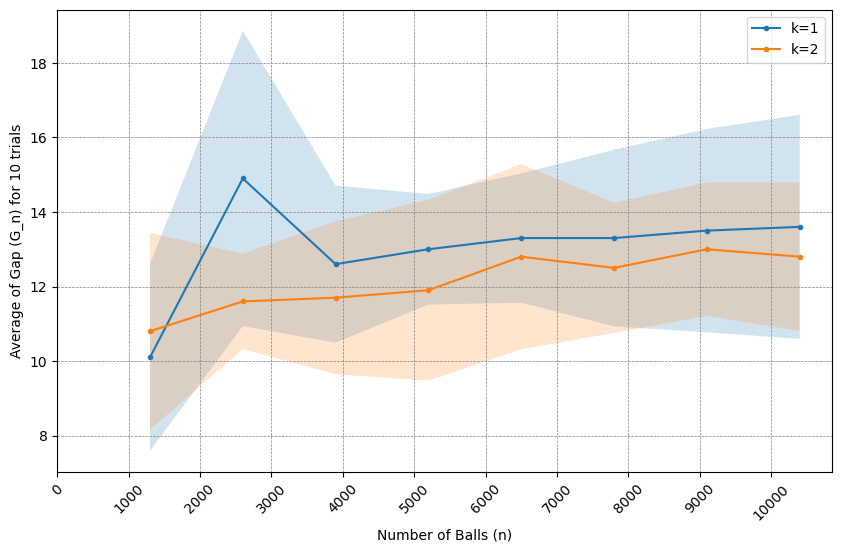

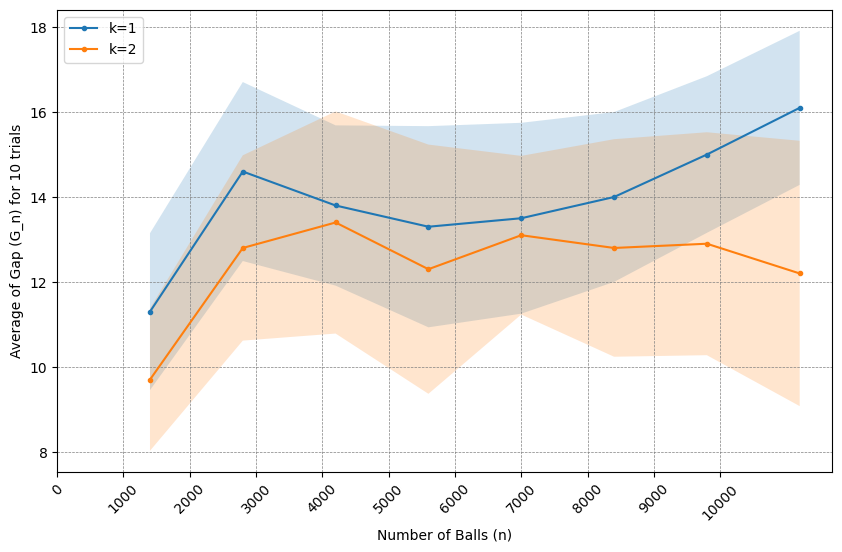

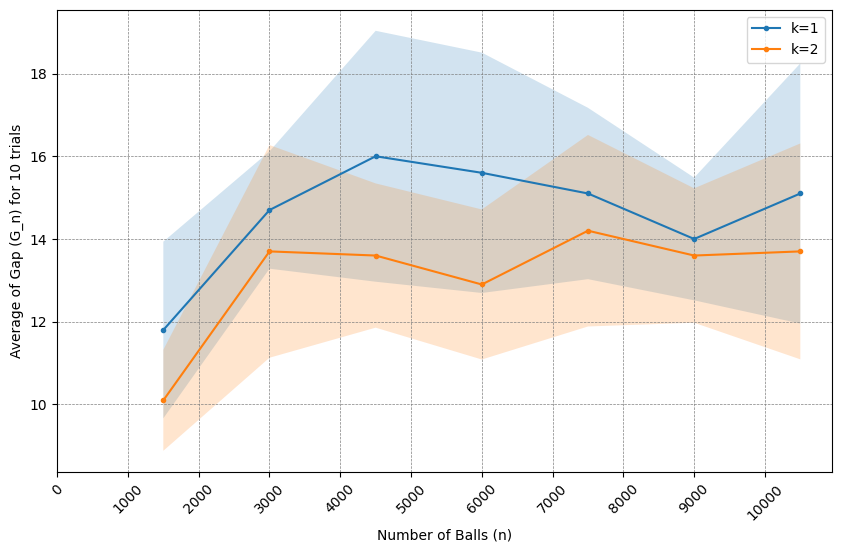

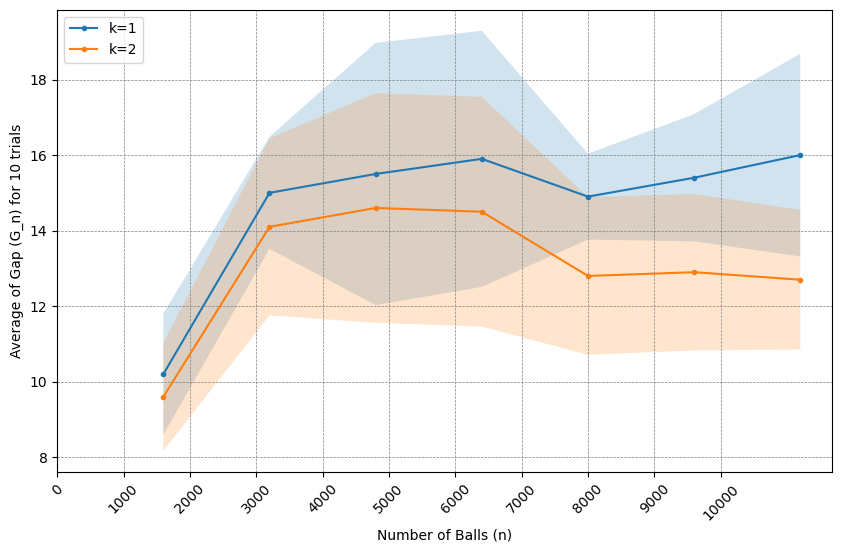

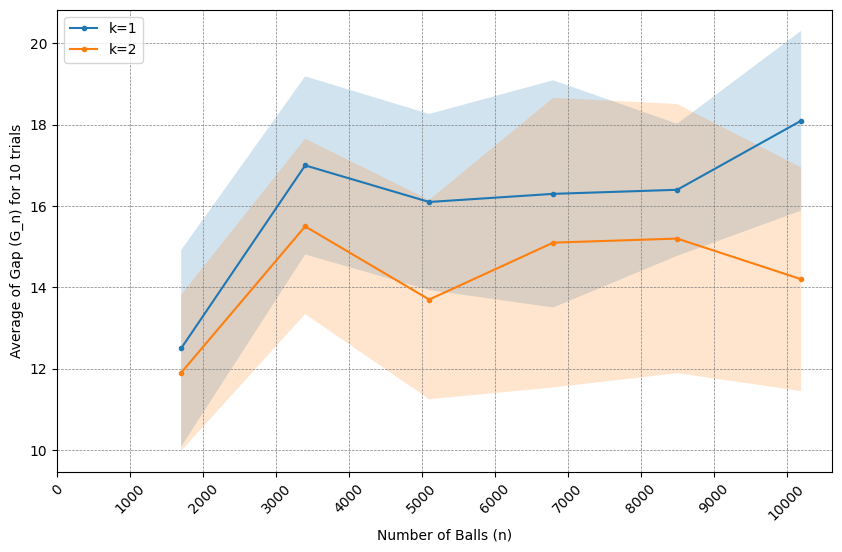

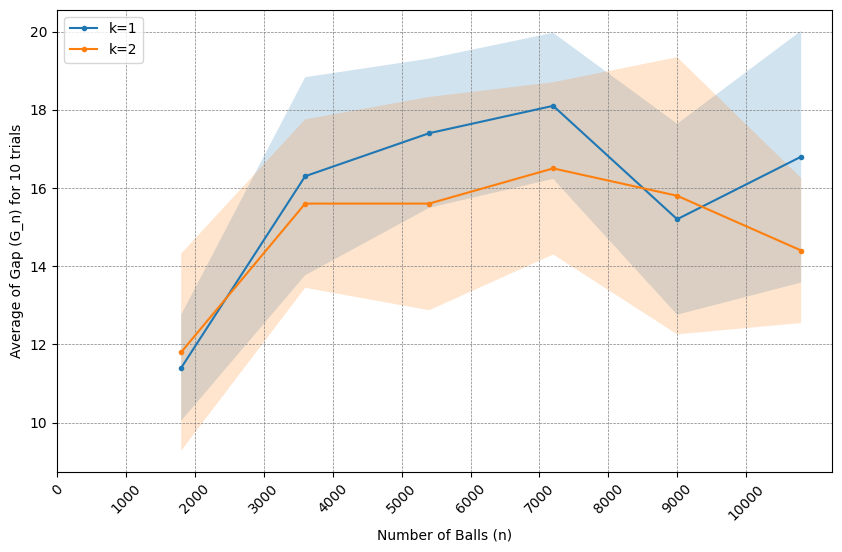

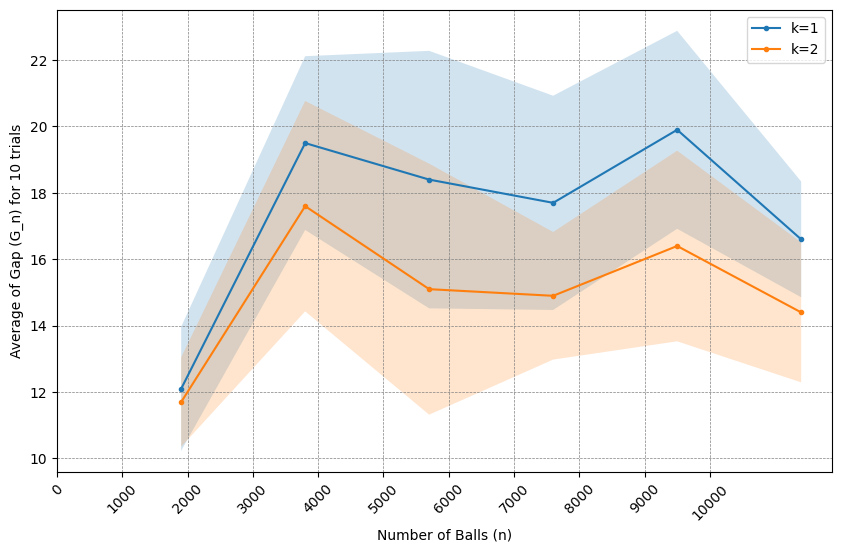

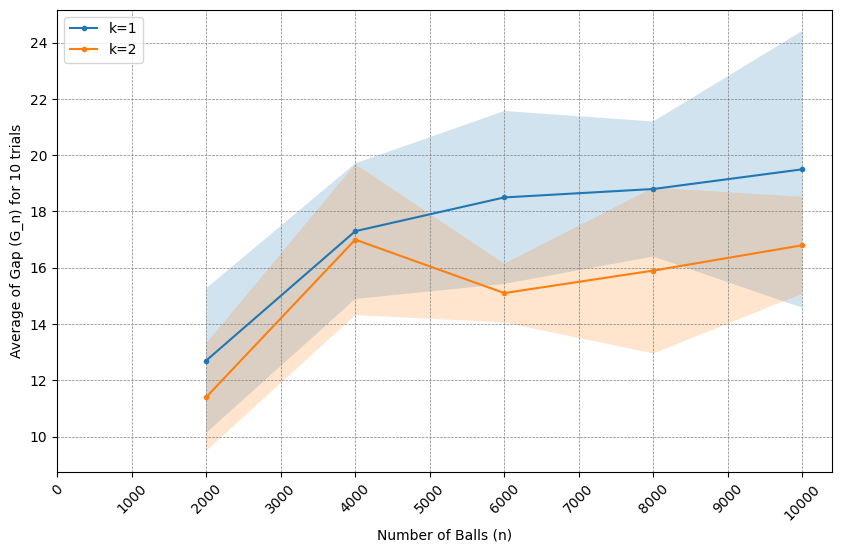

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

strategies = { 
               "k=1":  (partial_information, 1),
               "k=2" : (partial_information, 2) 
             }

for batch_size in d_batches:
    run_experiment(strategies, 
                    batch_size,
                    m,
                    T,
                    SAVE_FIGS, 
                    f"partial_information-{m}_m-{batch_size}_batch")